In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import shap
from statistics import mean, stdev
from sklearn import svm
from sklearn.preprocessing import StandardScaler


In [24]:
df = pd.read_csv("MyDataFinalCompositeScales.csv")

In [25]:
df.columns

Index(['pid', 'cid', 'hid', 'plj0433', 'age', 'sex', 'bula', 'employStat',
       'pgbilzeit', 'plb0471_v2', 'migback', 'plh0182', 'plh0176', 'plh0032',
       'plh0033', 'plh0335', 'plh0336', 'plh0038', 'plh0040', 'plj0046',
       'plj0047', 'plj0434', 'plj0435', 'bfi_consc', 'bfi_extrav', 'bfi_agree',
       'bfi_open', 'bfi_neurot', 'attitude', 'Con_Economic', 'Con_Security'],
      dtype='object')

# Data Normalization

In [27]:
scaler = StandardScaler()

In [31]:
# list of variables to be scaled
var_list = ["age", "pgbilzeit","plb0471_v2", "plh0182", "plh0176", 
            "plh0032", "plh0033", "plh0335", "plh0336", "plh0038", "plh0040", "plj0046", "plj0047",             
            "bfi_extrav", "bfi_neurot", "bfi_open", "bfi_agree", "bfi_consc",
            "plj0433", "plj0434"]

In [28]:
# list of variables to be scaled
var_list = ["age", "pgbilzeit","plb0471_v2", "plh0182", "plh0176", 
            "Con_Economic", "Con_Security",             
            "bfi_extrav", "bfi_neurot", "bfi_open", "bfi_agree", "bfi_consc",
            "plj0433", "plj0434"]

In [32]:
df[var_list] = scaler.fit_transform(df[var_list])

In [30]:
df.head()

,pid,cid,hid,plj0433,age,sex,bula,employStat,pgbilzeit,plb0471_v2,...,plj0434,plj0435,bfi_consc,bfi_extrav,bfi_agree,bfi_open,bfi_neurot,attitude,Con_Economic,Con_Security
0,5202,523,523,-0.273828,1.348956,2,2,2,-0.786697,-0.520667,...,-0.271288,5.0,0.184536,-1.118045,1.034816,0.306037,1.331064,2,-2.138181,-1.449607
1,9402,949,949,1.954508,0.707087,1,2,1,-0.249936,0.797283,...,0.092230,6.0,0.568350,0.651538,-1.432650,-0.568938,-0.865822,2,1.574654,1.163724
2,12501,1252,60330,0.468951,1.532346,1,1,2,0.823587,0.199525,...,1.182785,8.0,-0.583092,0.946469,0.329825,0.889354,-0.316601,3,-0.900570,-0.142942
3,13901,1392,1392,0.840340,0.982174,1,2,1,-0.428856,2.888239,...,0.819267,8.0,-0.583092,-0.233253,0.329825,0.306037,0.232621,3,1.574654,1.163724
4,18701,1872,1872,-0.273828,0.615392,2,1,2,0.644667,-0.424641,...,0.819267,6.0,-1.350720,-0.823114,-0.022670,-1.443913,1.880286,2,-0.900570,-1.449607


# Regression Anaylsis

In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [34]:
# first regression model: baseline features
base_model  = "plj0435 ~ age + pgbilzeit + plb0471_v2  + C(bula) + C(migback) + C(employStat) + C(sex)"
mod_base    = ols(base_model, data = df).fit()
print(mod_base.summary())  # 0.124

                            OLS Regression Results                            
Dep. Variable:                plj0435   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     70.36
Date:                Wed, 18 May 2022   Prob (F-statistic):          1.89e-137
Time:                        18:17:34   Log-Likelihood:                -15462.
No. Observations:                6795   AIC:                         3.095e+04
Df Residuals:                    6784   BIC:                         3.102e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.1956      0

## life satisfaction

In [36]:
# second model: inclusion of well-being variables
satis_base_model = "plj0435 ~ age + pgbilzeit + plb0471_v2  + C(bula) + C(migback) + C(employStat) + C(sex) + plh0182 + plh0176"
mod_base_satis = ols(satis_base_model, data = df).fit()
print(mod_base_satis.summary())

                            OLS Regression Results                            
Dep. Variable:                plj0435   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     67.92
Date:                Wed, 18 May 2022   Prob (F-statistic):          4.00e-157
Time:                        18:17:36   Log-Likelihood:                -15411.
No. Observations:                6795   AIC:                         3.085e+04
Df Residuals:                    6782   BIC:                         3.094e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.2126      0

In [38]:
# model comparison: well-being + baseline versus baseline
model_comp1 = anova_lm(mod_base, mod_base_satis)
print(model_comp1)

   df_resid           ssr  df_diff     ss_diff          F        Pr(>F)
0    6784.0  37683.343731      0.0         NaN        NaN           NaN
1    6782.0  37129.363748      2.0  553.979984  50.594622  1.546478e-22


In [40]:
#new model

satis_base_model_new = "plj0435 ~ age + pgbilzeit + plb0471_v2  + C(bula) + C(migback) + C(employStat) + C(sex) + plh0182"
mod_base_satis_new = ols(satis_base_model_new, data = df).fit()
print(mod_base_satis_new.summary())

                            OLS Regression Results                            
Dep. Variable:                plj0435   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     73.74
Date:                Wed, 18 May 2022   Prob (F-statistic):          2.67e-157
Time:                        18:17:42   Log-Likelihood:                -15413.
No. Observations:                6795   AIC:                         3.085e+04
Df Residuals:                    6783   BIC:                         3.093e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.2177      0

## Concerns

In [15]:
# third model: inclusion of concern variables
con_base_model = "plj0435 ~ age + pgbilzeit + plb0471_v2  + C(bula) + C(migback) + C(employStat) + C(sex) + plh0182 + Con_Economic + Con_Security"
mod_base_con  = ols(con_base_model, data = df).fit()
print(mod_base_con.summary())

                            OLS Regression Results                            
Dep. Variable:                plj0435   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     103.7
Date:                Sun, 15 May 2022   Prob (F-statistic):          5.42e-255
Time:                        18:01:51   Log-Likelihood:                -15181.
No. Observations:                6795   AIC:                         3.039e+04
Df Residuals:                    6781   BIC:                         3.049e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.1539      0

In [20]:
model_comp1 = anova_lm(mod_base_satis_new, mod_base_con)
print(model_comp1)

   df_resid           ssr  df_diff       ss_diff           F  Pr(>F)
0    6783.0  37148.975424      0.0           NaN         NaN     NaN
1    6775.0  26452.051942      8.0  10696.923482  342.467083     0.0


## Personality Traits

In [19]:
per_base_model = "plj0435 ~ age + pgbilzeit + plb0471_v2  + C(bula) + C(migback) + C(employStat) + C(sex) + plh0182 + Con_Economic + Con_Security + bfi_extrav + bfi_neurot + bfi_open + bfi_agree + bfi_consc"
mod_base_per  = ols(per_base_model, data = df).fit()
print(mod_base_per.summary())


                            OLS Regression Results                            
Dep. Variable:                plj0435   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     86.43
Date:                Sun, 15 May 2022   Prob (F-statistic):          4.88e-287
Time:                        18:01:52   Log-Likelihood:                -15095.
No. Observations:                6795   AIC:                         3.023e+04
Df Residuals:                    6776   BIC:                         3.036e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.1597      0

In [21]:
model_comp2 = anova_lm(mod_base_con, mod_base_per)
print(model_comp2)

   df_resid           ssr  df_diff    ss_diff          F        Pr(>F)
0    6781.0  34695.496441      0.0        NaN        NaN           NaN
1    6776.0  33825.074191      5.0  870.42225  34.873426  2.476174e-35


## Threats

In [23]:
threat_base_model = "plj0435 ~ age + pgbilzeit + plb0471_v2  + C(bula) + C(migback) + C(employStat) + C(sex) + plh0182 + Con_Economic + Con_Security + bfi_extrav + bfi_neurot + bfi_open + bfi_agree + bfi_consc + plj0433 + plj0434"
mod_base_threat  = ols(threat_base_model, data = df).fit()
print(mod_base_threat.summary())


                            OLS Regression Results                            
Dep. Variable:                plj0435   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     640.3
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        18:03:38   Log-Likelihood:                -12191.
No. Observations:                6795   AIC:                         2.442e+04
Df Residuals:                    6774   BIC:                         2.457e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.2588      0

In [ ]:
model_comp3 = anova_lm(mod_base_per, mod_base_threat)
print(model_comp3)

# xgboost & Shap

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import shap

In [3]:
df = pd.read_csv("MyDataFinalCompositeScales.csv")

In [4]:
df.rename(columns = {'bula':'fedState', 'pgbilzeit':'eduYears', 'plb0471_v2': "income", "migback": "migBack", "plh0182":"currLifeSatis",
                         "plh0176": "perIncomeSatais", "plj0433": "ecoThreat", "plj0434": "cultThreat", 'bfi_consc':"Conscientiousness", 'bfi_extrav':"Extraversion", 'bfi_agree':"Agreeableness", 'bfi_open':"Openness", 'bfi_neurot':"Neuroticism"}, inplace = True)

In [5]:
df.columns

Index(['pid', 'cid', 'hid', 'ecoThreat', 'age', 'sex', 'fedState',
       'employStat', 'eduYears', 'income', 'migBack', 'currLifeSatis',
       'perIncomeSatais', 'plh0032', 'plh0033', 'plh0335', 'plh0336',
       'plh0038', 'plh0040', 'plj0046', 'plj0047', 'cultThreat', 'plj0435',
       'Conscientiousness', 'Extraversion', 'Agreeableness', 'Openness',
       'Neuroticism', 'attitude', 'Con_Economic', 'Con_Security'],
      dtype='object')

In [7]:
X = df[['age', 'sex', 'fedState', 'employStat', 'eduYears', 'income', 'migBack', "currLifeSatis", "perIncomeSatais", 
        'Con_Economic', 'Con_Security', 'Conscientiousness', 'Extraversion', 'Agreeableness',
        'Openness', 'Neuroticism', "ecoThreat", "cultThreat"]]

#df['Multiclass'] = np.where(df['plj0435']> 7 , 'positive',  # 2 = 'Best', 1 = 'Premium', 0 = 'Value'
                      #np.where(df['plj0435']> 3, 'moderate','negative'))

    
df['Multiclass'] = np.where(df['plj0435']> 7 , 2,  # 2 = 'Best', 1 = 'Premium', 0 = 'Value'
                      np.where(df['plj0435']> 4, 1, 0))
    
y = df[['Multiclass']]

In [9]:
df.Multiclass.value_counts(normalize =True)

1    0.461516
0    0.372038
2    0.166446
Name: Multiclass, dtype: float64

In [11]:
df.Multiclass.value_counts()

1    3136
0    2528
2    1131
Name: Multiclass, dtype: int64

In [12]:
df['plj0435'].value_counts()

6.0     2077
3.0      714
4.0      676
1.0      667
5.0      547
7.0      512
2.0      471
8.0      442
9.0      379
10.0     170
11.0     140
Name: plj0435, dtype: int64

In [13]:
shap.initjs()

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train, Y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[23:50:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

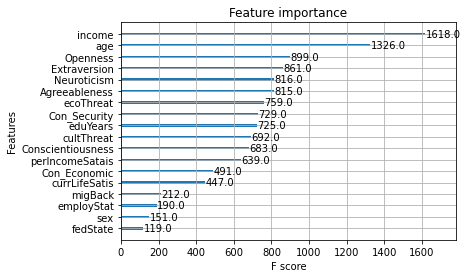

In [15]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

In [16]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
#shap.summary_plot(shap_values, X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [17]:
np.shape(shap_values)

(3, 6795, 18)

In [18]:
np.shape(shap_values[0])

(6795, 18)

In [19]:
len(X.columns)

18

## 0

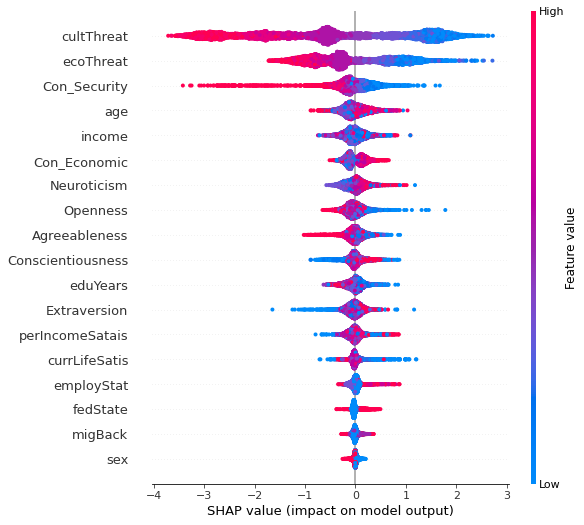

In [20]:
shap_values = explainer.shap_values(X)
fig = plt.figure(figsize=(3,3)) # moderate
shap.summary_plot(shap_values[0], X.values, feature_names= X.columns, show=False)
plt.savefig('shap0.pdf', bbox_inches = 'tight')  # remove plt.shoe() to get the pdf

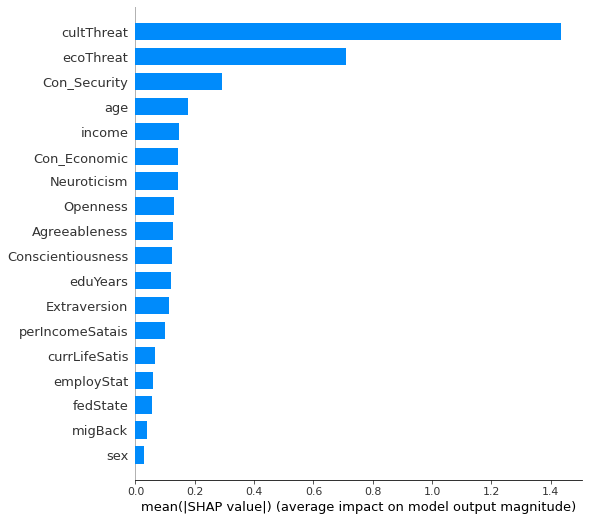

In [21]:
fig = plt.figure(figsize=(3,3)) # moderate
shap.summary_plot(shap_values[0], X.values, feature_names= X.columns, show=False, plot_type="bar")
plt.savefig('bar0.pdf', bbox_inches = 'tight')  # remove plt.shoe() to get the pdf

## 1


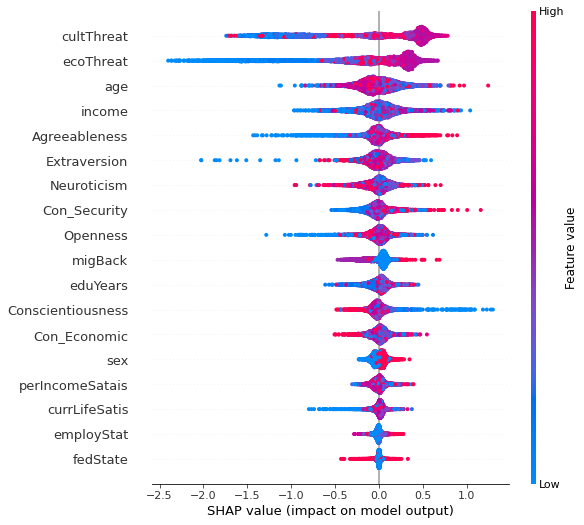

In [22]:
fig = plt.figure(figsize=(3,3))
shap.summary_plot(shap_values[1], X.values, feature_names= X.columns, show=False)
plt.savefig('shap1.pdf', bbox_inches = 'tight')

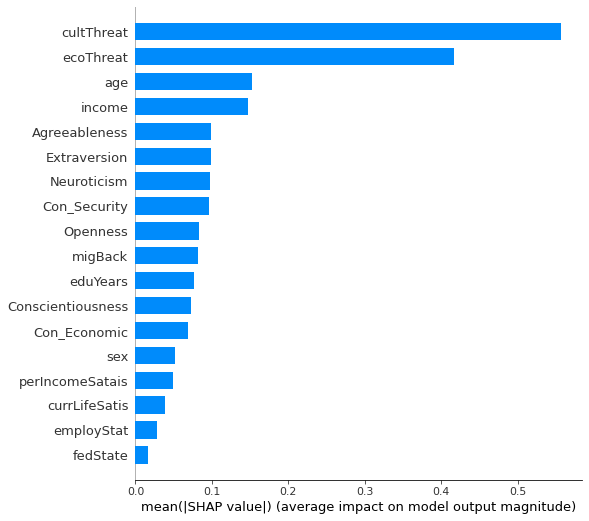

In [23]:
fig = plt.figure(figsize=(3,3)) # moderate
shap.summary_plot(shap_values[1], X.values, feature_names= X.columns, show=False, plot_type="bar")
plt.savefig('bar1.pdf', bbox_inches = 'tight')  # remove plt.shoe() to get the pdf

## 2

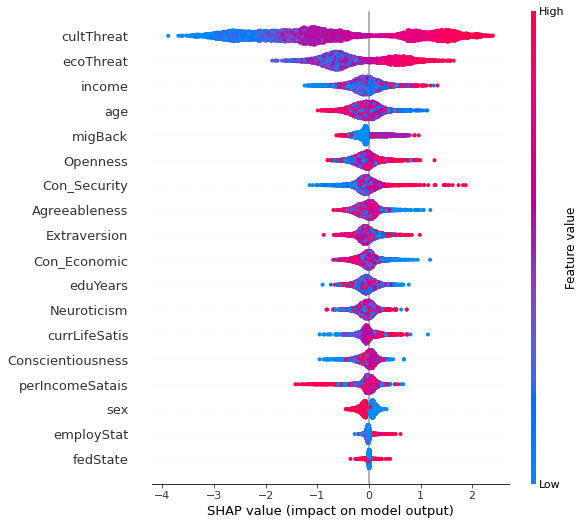

In [24]:
fig = plt.figure(figsize=(3,3)) # moderate
shap.summary_plot(shap_values[2], X.values, feature_names= X.columns, show=False)
plt.savefig('shap2.pdf', bbox_inches = 'tight')  # remove plt.shoe() to get the pdf


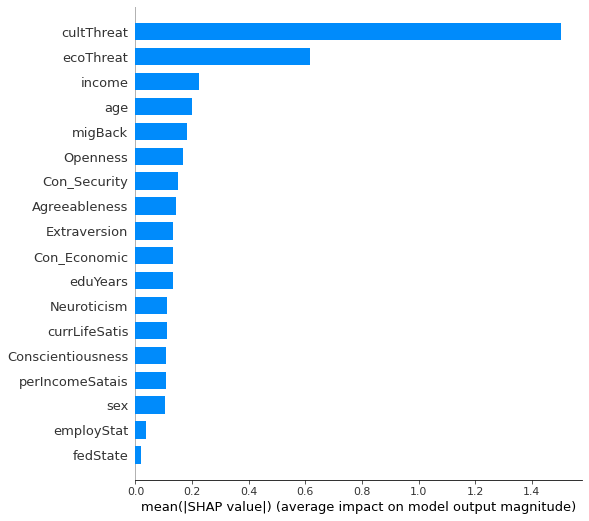

In [25]:
fig = plt.figure(figsize=(3,3)) # moderate
shap.summary_plot(shap_values[2], X.values, feature_names= X.columns, show=False, plot_type="bar")
plt.savefig('bar2.pdf', bbox_inches = 'tight')  # remove plt.shoe() to get the pdf

In [26]:
multiclass_actual_pred = pd.DataFrame(xgb_model.predict_proba(X_test)).round(2)
multiclass_actual_pred['Actual'] = Y_test.values
multiclass_actual_pred['Pred'] = xgb_model.predict(X_test)
print(classification_report(multiclass_actual_pred['Actual'], multiclass_actual_pred['Pred']))    


              precision    recall  f1-score   support

           0       0.79      0.76      0.77       522
           1       0.66      0.72      0.69       617
           2       0.58      0.49      0.53       220

    accuracy                           0.70      1359
   macro avg       0.68      0.66      0.66      1359
weighted avg       0.70      0.70      0.70      1359



In [27]:
X_test.shape

(1359, 18)

In [28]:
Y_test['Multiclass'].value_counts()

1    617
0    522
2    220
Name: Multiclass, dtype: int64

In [29]:
Y_train['Multiclass'].value_counts()

1    2519
0    2006
2     911
Name: Multiclass, dtype: int64

In [30]:
Y_test.columns

Index(['Multiclass'], dtype='object')

In [31]:
multiclass_actual_pred.columns = ['positive','middle','negative','Pred','Actual']
pd.crosstab(multiclass_actual_pred['Actual'],multiclass_actual_pred['Pred'])

Pred,0,1,2
Actual,,,
0,397,98,9
1,122,443,103
2,3,76,108


In [32]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test,approximate=True)
#plt.title('The Summary Plot for the Multiclass Model'+'\n'+'Class 2 - moderate, Class 1 - positive, Class 0 - hostile')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


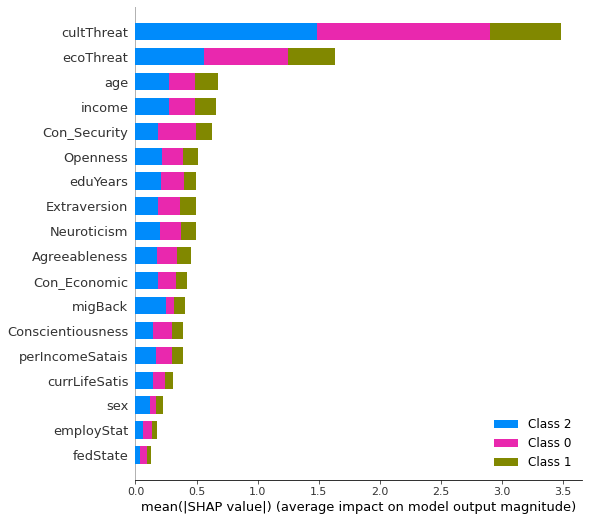

In [33]:
fig = plt.figure(figsize=(5,5))
shap.summary_plot(shap_values, X
                  , show = False)
plt.savefig('shapALL.pdf', bbox_inches = 'tight')